In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self, text_embedding_dim, graph_embedding_dim, hidden_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(text_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, graph_embedding_dim),
            nn.Tanh()
        )

    def forward(self, text_embedding):
        graph_embedding = self.model(text_embedding)
        return graph_embedding

In [3]:
# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, text_embedding_dim, graph_embedding_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(text_embedding_dim + graph_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout to prevent discriminator from becoming too confident
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, text_embedding, graph_embedding):
        combined = torch.cat((text_embedding, graph_embedding), dim=1)
        validity = self.model(combined)
        return validity

In [4]:
# Define a custom dataset
class EmbeddingDataset(Dataset):
    def __init__(self, text_embeddings, graph_embeddings):
        self.text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)
        self.graph_embeddings = torch.tensor(graph_embeddings, dtype=torch.float32)
    
    def __len__(self):
        return len(self.text_embeddings)
    
    def __getitem__(self, idx):
        text_embedding = self.text_embeddings[idx]
        graph_embedding = self.graph_embeddings[idx]
        return text_embedding, graph_embedding

In [5]:
import json
import numpy as np
total_obj=1136
paragraphs = []
with open('../../ics_cwe/id_to_desc.json') as fp:
    id_to_desc = json.load(fp)
for i in range(total_obj):
    paragraphs.append(id_to_desc[str(i)])
graph_embeddings = np.load("../../ics_cwe/{}/sample_{}/{}/text_hop_dual_gm_1.0.npy".format("GCN",4,"pt_Gpt2"))
text_embeddings = np.load("../../ics_cwe/Text_Hop/{}/data/all_embeddings.npy".format("pt_Gpt2"))

In [6]:
# Hyperparameters
text_embedding_dim = text_embeddings.shape[1]  # Example text embedding dimension
graph_embedding_dim = graph_embeddings.shape[1]  # Desired graph embedding dimension
hidden_dim = 128
lr = 0.0002
batch_size = 64
shuffle = True
epochs = 10000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Create the dataset
embedding_dataset = EmbeddingDataset(text_embeddings, graph_embeddings)
# Create the DataLoader
embedding_dataloader = DataLoader(embedding_dataset, batch_size=batch_size, shuffle=shuffle)

In [8]:
# Instantiate the networks and move to device
generator = Generator(text_embedding_dim, graph_embedding_dim, hidden_dim).to(device)
discriminator = Discriminator(text_embedding_dim, graph_embedding_dim, hidden_dim).to(device)


In [9]:
# # Loss and optimizers
# adversarial_loss = nn.BCELoss().to(device)
# optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# Loss and optimizers
adversarial_loss = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [10]:
# Training the cGAN
epochs = 10000

for epoch in range(epochs):
    for i, (real_text_embeddings, real_graph_embeddings) in enumerate(embedding_dataloader):
        batch_size = real_text_embeddings.size(0)

        # Move data to device
        real_text_embeddings = real_text_embeddings.to(device)
        real_graph_embeddings = real_graph_embeddings.to(device)

        # Adversarial ground truths with one-sided label smoothing
        valid = torch.full((batch_size, 1), 0.9, device=device, requires_grad=False)  # Valid labels as 0.9
        fake = torch.zeros((batch_size, 1), device=device, requires_grad=False)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate graph embeddings
        generated_graph_embeddings = generator(real_text_embeddings)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(real_text_embeddings, generated_graph_embeddings), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real graph embeddings
        real_loss = adversarial_loss(discriminator(real_text_embeddings, real_graph_embeddings), valid)
        # Loss for fake graph embeddings
        fake_loss = adversarial_loss(discriminator(real_text_embeddings, generated_graph_embeddings.detach()), fake)
        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
    if(epoch%100==0):
        print(f"Epoch [{epoch}/{epochs}]  D Loss: {d_loss.item()}  G Loss: {g_loss.item()}")


Epoch [0/10000]  D Loss: 0.6525412201881409  G Loss: 0.8440119028091431
Epoch [100/10000]  D Loss: 0.5759603977203369  G Loss: 1.0861787796020508
Epoch [200/10000]  D Loss: 0.4503016769886017  G Loss: 1.7135488986968994
Epoch [300/10000]  D Loss: 0.38879868388175964  G Loss: 2.5334699153900146
Epoch [400/10000]  D Loss: 0.32022085785865784  G Loss: 4.027320861816406
Epoch [500/10000]  D Loss: 0.3064548671245575  G Loss: 4.074382781982422
Epoch [600/10000]  D Loss: 0.3373211622238159  G Loss: 5.704192161560059
Epoch [700/10000]  D Loss: 0.3251168727874756  G Loss: 3.1598892211914062
Epoch [800/10000]  D Loss: 0.25847765803337097  G Loss: 5.132763385772705
Epoch [900/10000]  D Loss: 0.3123408555984497  G Loss: 4.798542022705078
Epoch [1000/10000]  D Loss: 0.24373558163642883  G Loss: 7.013507843017578
Epoch [1100/10000]  D Loss: 0.27664074301719666  G Loss: 5.848641395568848
Epoch [1200/10000]  D Loss: 0.23132091760635376  G Loss: 8.117480278015137
Epoch [1300/10000]  D Loss: 0.251870065

In [11]:
# Path to save the model
model_save_path = 'generator_model.pth'

# Save the state dictionary of the generator
torch.save(generator.state_dict(), model_save_path)

print(f"Generator model saved to {model_save_path}")

Generator model saved to generator_model.pth


In [59]:
def generate_graph_emb(org_emb):
    generator.load_state_dict(torch.load('data/generator_model_d0.3.pth'))  # Load the trained model weights
    generator.eval()  # Set the generator to evaluation mode
    
    # Load new text embeddings
    new_text_embeddings = org_emb
    new_text_embeddings = torch.tensor(new_text_embeddings, dtype=torch.float32).to(device)
    
    # Generate graph embeddings for the new text embeddings
    with torch.no_grad():  # Disable gradient calculation
        generated_graph_embeddings = generator(new_text_embeddings)
    
    # Convert the generated embeddings back to numpy if needed
    generated_graph_embeddings = generated_graph_embeddings.cpu().numpy()
    
    print("Generated Graph Embeddings:", generated_graph_embeddings)
    return generated_graph_embeddings

In [60]:
# with open("../../ics_cwe/Text_Hop/{}/data/GAN_generated_d0.3.npy".format("pt_Gpt2"), 'wb') as f:
#     np.save(f,generated_graph_embeddings)

In [61]:
# generated_graph_embeddings.shape

In [62]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
with open("data/noisy_text_embeddings.npy", 'rb') as f:
    noisy_embeddings = np.load(f)

In [64]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def get_sim(gen_emb, org_emb):
    # Compute the cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(gen_emb, org_emb)
    diagonal_values = np.diagonal(cosine_sim_matrix)
    # print(cosine_sim_matrix.shape)  # Should print (203, 933)
    return diagonal_values

In [65]:
import numpy as np
import random
from matplotlib import pyplot as plt
def plot(sim_vec, title):
    plt.figure(figsize=(5, 5))
    plt.hist(sim_vec, bins=np.arange(0, 1.1, 0.05), edgecolor='black')  
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.savefig(title+".png", dpi=300, bbox_inches='tight')
    # Show plot
    plt.show()

In [66]:
graph1 = generate_graph_emb(text_embeddings)

Generated Graph Embeddings: [[ 0.9883547  -0.21760763 -0.9035992  ...  0.17018697  0.52112764
   0.8236704 ]
 [ 0.11987268 -0.9916278  -0.7708344  ...  0.5253801   0.03887662
   0.66942954]
 [ 0.5449523   0.186009    0.12296677 ...  0.47060066 -0.2930091
  -0.86553454]
 ...
 [ 0.56601495  0.28900534  0.5019779  ... -0.21147366  0.6013636
   0.84411836]
 [ 0.8137145   0.57609135 -0.71597266 ...  0.31762552  0.48082724
   0.7058817 ]
 [-0.9313541   0.88579947 -0.54730064 ...  0.97995913  0.63029486
  -0.31311926]]


In [67]:
graph2 = generate_graph_emb(noisy_embeddings)

Generated Graph Embeddings: [[ 0.998845    0.22782151 -0.62010646 ...  0.05948895  0.70344114
   0.9747269 ]
 [-0.3373369  -0.9963947  -0.8349416  ...  0.2345557   0.32845348
   0.75888366]
 [ 0.60927653  0.00238498  0.34582797 ... -0.03323781 -0.3223093
  -0.4726353 ]
 ...
 [ 0.32213926  0.10857248  0.3314551  ...  0.46166334  0.24372658
   0.8475262 ]
 [ 0.47393507  0.5094428  -0.84715194 ...  0.72308004  0.367143
   0.19690637]
 [-0.9548      0.9498407  -0.64971983 ...  0.9990231   0.33942425
  -0.7152524 ]]


In [68]:
sim_vec1 = get_sim(graph1, graph_embeddings)

In [69]:
sim_vec2 = get_sim(graph2, graph_embeddings)

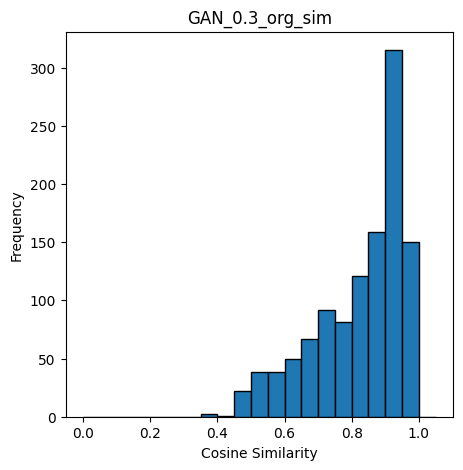

In [70]:
plot(sim_vec1, "GAN_0.3_org_sim")

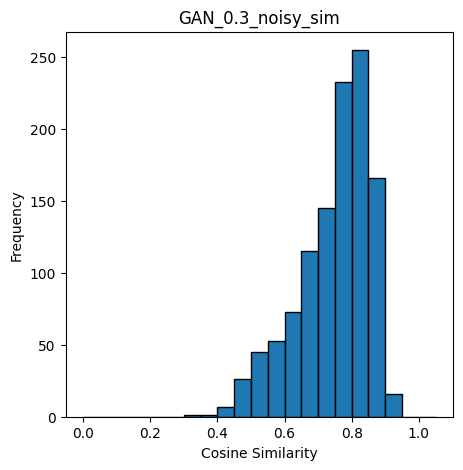

In [71]:
plot(sim_vec2, "GAN_0.3_noisy_sim")